# Dereverb - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: , MATR: 953546 )

Import libraries:

In [840]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
import acoustics as ac
import scipy.signal as signal
# from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import soundfile as sf
from pyAudioAnalysis import audioSegmentation as aS

### Part 1: RIR and reverberation
From the image we can see that values of beta should be chosen between 0.2 for small rooms (4 m per side) and 1.8 for very big rooms (30 m per side);

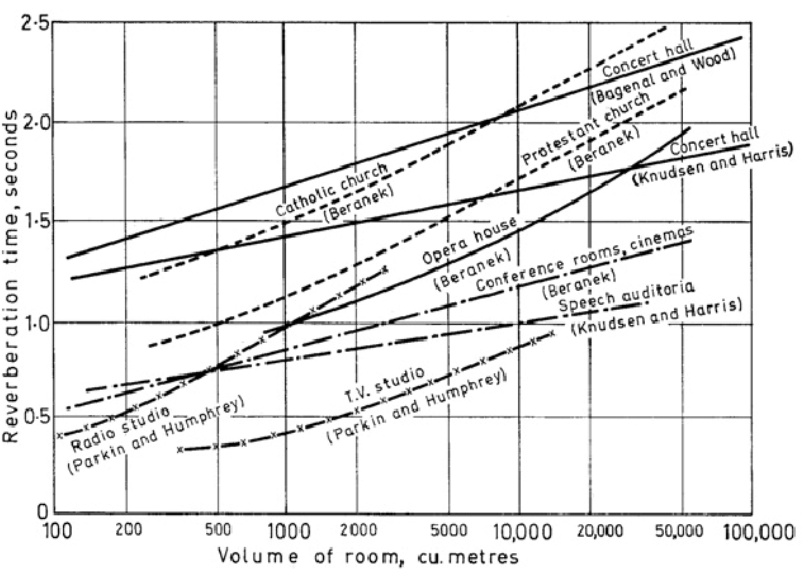

In [841]:
ipd.Image(filename = "images/RevTime1.png", width = 600, height = 300)

Let's define some parameters:

In [842]:
fs = 22500 # sampling rate (Hz)

rt60_tgt = 0.7  # reverberation time (s)
room_dim = [10, 7.5, 3.5]  # room dimensions (m)

source_pos = [5, 1, 1] # x, y, z position of the source (m)
mic_locs = np.c_[ [4.7, 5, 1.2], [5.3, 5, 1.2] ] # location of the microphone / microphone array (m)

Visualization of the room with source and mics:

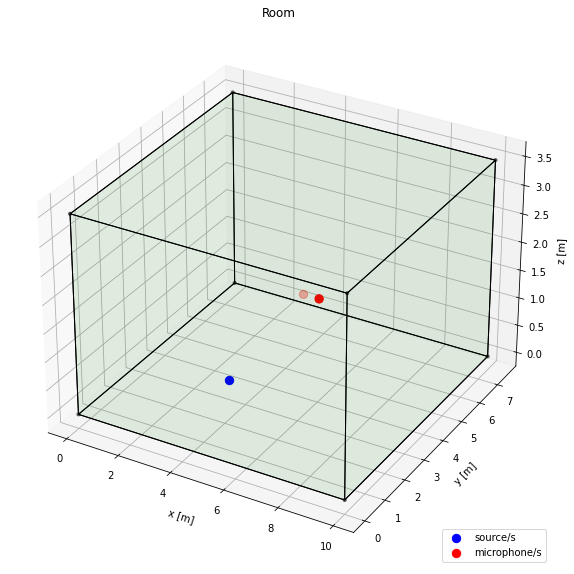

In [843]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70)
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70)

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

Now generate the RIR and apply it to the audio files

In [844]:
# import a mono wavfile as the source signal: the sampling frequency should match that of the room
#  OSR_us_000_0010_8k.wav AudioSamples/Voice_ChangeHasComeToAmerica.wav

audio, fs = librosa.load('audio/OSR_us_000_0010_8k.wav', sr=fs)
audio=audio[:5*fs]

In [845]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

The volume of the room is 262.5 m³


In [846]:
# place the source in the room
room.add_source(source_pos, signal=audio); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [847]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
room.mic_array.to_wav(
    f"audio/generated/voiced_aREV.wav",
    norm=True,
    bitdepth=np.int16,
)

x_rev = room.mic_array.signals[0, :];

global_delay = pra.constants.get("frac_delay_length") // 2

print('Global delay introduced by the simulation:', global_delay)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[0, 0]))

Global delay introduced by the simulation: 40
The desired RT60 was 0.7 s
The measured RT60 is 1.1528 s


*Do we need to take into account the global delay when computing filters?*

Original signal: (112500,)
RIR: (2, 1, 49300)
Reverberated signal: (161800,)


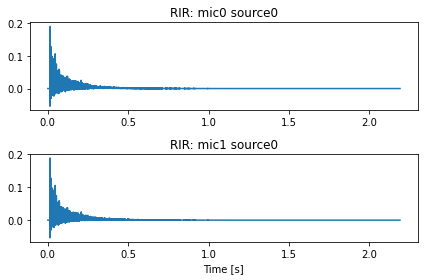

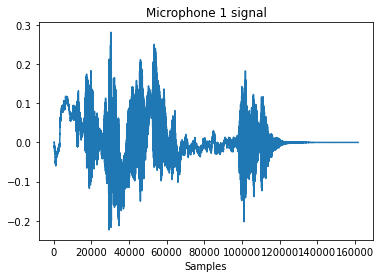

In [848]:
# Plot the RIRs
room.plot_rir()

plt.figure()
# plot signal at microphone 1
plt.plot(room.mic_array.signals[0, :])
plt.title("Microphone 1 signal")
plt.xlabel("Samples");


print('Original signal:', audio.shape)
print('RIR:', np.array(room.rir).shape )
print('Reverberated signal:', np.array(room.mic_array.signals[0, :]).shape)

In [849]:
# save RIR into a wav
# sf.write('audio/RIR.wav', np.array(np.squeeze(room.rir)), samplerate=fs)

#### Audio files
Dry signal:

In [850]:
ipd.display(ipd.Audio(audio, rate=fs))

Reverberated signal:

In [851]:
ipd.display(ipd.Audio(room.mic_array.signals[0, :], rate=fs))

###COMPLEX CEPSTRUM 
we try to define our oun function since the acoustic one seems to not behave correctly



### Estimation of h:
*  Window the signal in a series of frames
*  Compute complex cepstrum of each frame
*  Estimate $\hat{h}_{est}$ as:
$$\hat{h}_{est}(q,\tau)=\frac{1}{L}\cdot\sum\limits_{l=\tau}^{\tau+L-1}\hat{x}(q,l)$$

## Standard segmentation

### Avoid cross-talking between frames:
Segment the signal and use only speech parts in order to compute $h_{est}$

### Audio segmentation using pyAudioAnalyisis

### Minimum-Phase/Allpass Decomposition: Standard Approach

**NOTATION:**
*  k = time sample
*  K = number of time samples
*  n = frequency bin
*  N = number of frequency bins

1. Compute the discrete Fourier transform (DFT) of \\(h(k)\\), or \\(H(n)\\)

2. Compute the logarithm of the frequency response, as \\(\hat{H}(n) = \log|H(n)| + j\arg(H(n))\\)

3. Compute the even part of the complex cepstrum as: \\[\hat{h}_e(k) = \frac{1}{N}\sum_{n=0}^{N-1} \log|H(n)|e^{j(2\pi/N)kn} \\] where \\(k = 0,1,2,...,N-1\\)

4. Calculate the corresponding complex cepstrum of the minimum phase sequence: \\[\hat{h}_{mp}(k) = \begin{cases} \hat{h}_e(k), & k=0,N/2 \\ 2\hat{h}_e(k), & 1\leq k < N/2\\ 0, & N/2 < k \leq N-1 \end{cases} \\]

5. Compute the DFT of \\(\hat{h}_{mp}(k)\\), as: \\[ \hat{H}_{mp}(n) = \sum_{n=0}^{N-1} \hat{h}_{mp}(k)e^{-j(2\pi/N)kn}\\]

6. Infer the minimum phase part of \\(H(n)\\), as \\(H_{mp}(n) = exp[\hat{H}_{mp}(n)]\\)

Now that \\(H_{mp}(n)\\) is known, the remaining allpass component can be computed as \\(H_{ap}(n)= H(n)G_{mp}(n)\\), where \\(G_{mp}(n)=1/H_{mp}(n)\\) is the minimum phase inverse.

Apply to signal and see the result:

#### Audio files comparison

#### RIR Comparison (Standard Approach)

### Minimum-Phase/Allpass Decomposition: Novel Approach

1. Calculate $H(n)$, $\hat{H}(n)$, $\hat{h}_{e}(k)$, as we already did before.

2. Calculate the corresponding complex cepstrum of the minimum phase sequence: $$\hat{h}_{mp}^{1/L}(k) = \begin{cases} \hat{h}_e(k)/L, & k=0,N/2 \\ 2\hat{h}_e(k)/L, & 1\leq k < N/2\\ 0, & N/2 < k \leq N-1 \end{cases} $$

3. Compute the DFT of $\hat{h}_{mp}^{1/L}(k)$, $\hat{H}_{mp}^{1/L}(k)$

4. Infer the minimum phase part $H_{mp}^{1/L}(k)$, as the exponential function of $\hat{H}_{mp}^{1/L}(k)$

5. Calculate the frequency response $H^{(l+1)}(n)$, as: $$H^{(l+1)}(n)= \frac{H^{(l)}(n)}{H^{1/L}_{mp}(n)}$$

where $H^{(l+1)}(n)$ denotes the partly equalized room transfer function resulting from the $(l+1)^{th}$ stage of computation $(l = 0,1,. . . , L-1)$,
and $H^{(0)}(n) = H(n)$

### Graph comparison:

### Phase Equalization